# imports

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython.display import clear_output

import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

import numpy as np

from copy import deepcopy

## Домашнее задание 1. Обучение LeNet

На прошлой лабораторной мы рассмотрели пример обучения небольшой нейронной сети для классификации датасета CIFAR-10. В качестве домашнего задания вам предлагается классификация предметов одежды из датасета [**Fashion MNIST**](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST). Вы можете начать с имплементации классической сверточной сети [LeNet](https://en.wikipedia.org/wiki/LeNet) и улучшить ее методами, которые мы обсудили на лекции (dropout, batchnorm, etc).

### Загрузка датасета

In [43]:
# Гиперпараметры
BATCH_SIZE = 128

In [44]:
def build_dataloaders(dataset, test_size=0.1):
    # Содержит 60000 семплов и 10 классов
    images = dataset.data.view([60000, 1, 28, 28]).float()

    labels = deepcopy(dataset.targets) #- 1

    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=test_size)

    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    batch_size = 128

    train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_dl = DataLoader(val_data, batch_size=len(val_data), pin_memory=True)
    return train_dl, val_dl

def show_images_from_dataset(current_dataset, etalon_dataset):
    # Показать примеры картинок из датасета
    images = [current_dataset[i][0] for i in range(8)]
    images.extend([etalon_dataset[i][0] for i in range(8)])
    grid = make_grid(images, nrow=8)
    plt.figure(figsize=(15, 4))
    plt.imshow(grid.permute(1, 2, 0));


def show_class_distribution(dataset):
    """Показать распределение классов в датасете"""
    print("Распределение классов в датасете:")
    target_indexes = dataset.targets.clone().detach() 
    plt.figure(figsize=(3,3))
    plt.bar(dataset.targets.unique(), target_indexes.bincount(), width=0.4)
    plt.show()

def calc_mean_and_std(dataset):
    """ Расчет среднего и отклонения для нормализации """
    data = torch.cat([img for img, _ in dataset], dim=0)
    mean = data.mean().item()
    std = data.std().item()
    print(f"Mean: {mean:.4f}, Std: {std:.4f}")    
    return mean, std

In [45]:
subset_size = 1500

In [46]:
transform = v2.Compose([v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True)]
)
# загрузка датасетов без нормализации
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
#test_dataset_subset = torch.utils.data.Subset(test_dataset, range(subset_size))
#№test_loader = DataLoader(test_dataset_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(train_loader.dataset.data.shape, test_loader.dataset.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


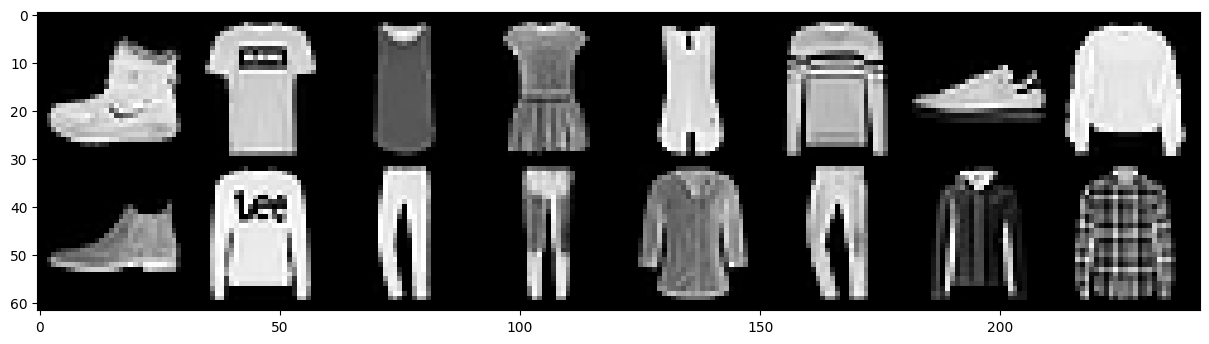

In [47]:
# Изображения тренировочного (1-я строка) и тестового (2-я) датасетов
show_images_from_dataset(train_loader.dataset, test_loader.dataset)

In [48]:
# расчет параметров для нормализации данных
mean, std = calc_mean_and_std(train_dataset)

Mean: 0.2860, Std: 0.3530


In [49]:
# трансформер для нормализации данных
transform_norm = v2.Compose([v2.ToImage(), 
                             v2.ToDtype(torch.float32, scale=True),
                             v2.Normalize((mean,), (std,))]
)
# трансформер для нормализации и аугментации данных
transform_norm_aug = v2.Compose([v2.ToImage(), 
                                 v2.RandomHorizontalFlip(),  # Случайное отражение
                                 v2.RandomVerticalFlip(),  # Случайное отражение        
                                 v2.RandomRotation(15),      # Поворот ±15 градусов
                                 v2.ToDtype(torch.float32, scale=True),
                                 v2.Normalize((mean,), (std,))]
)

In [50]:
# загрузка датасета с нормализацией
train_dataset_norm = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_norm
)
test_dataset_norm = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform_norm
)
train_loader_norm = DataLoader(train_dataset_norm, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
#test_dataset_norm_subset = torch.utils.data.Subset(train_dataset_norm, range(subset_size))
#test_loader_norm = DataLoader(test_dataset_norm_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader_norm = DataLoader(test_dataset_norm, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(train_loader_norm.dataset.data.shape, test_loader_norm.dataset.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


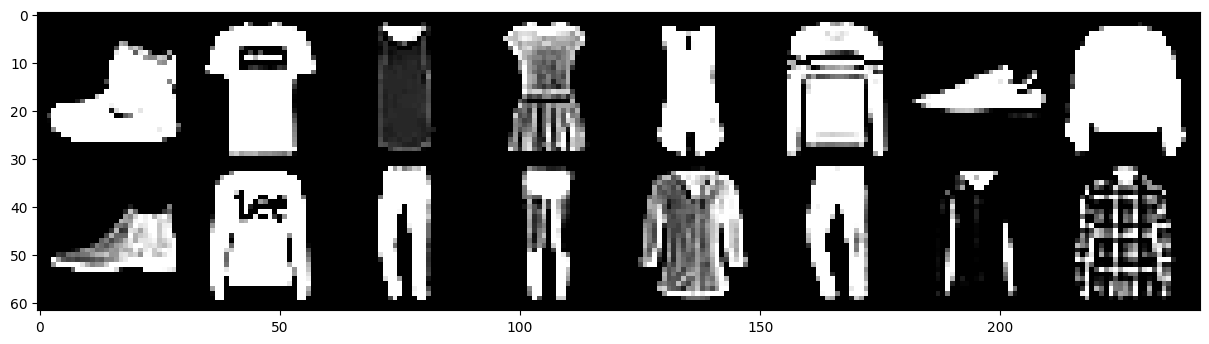

In [51]:
# Изображения тренировочного (1-я строка) и тестового (2-я) датасетов
show_images_from_dataset(train_loader_norm.dataset, test_loader_norm.dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


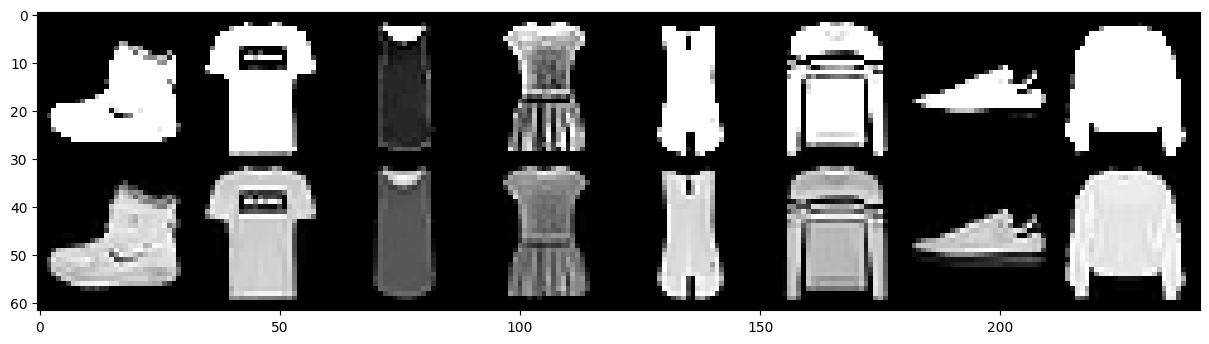

In [52]:
# Изображения с нормализацией (1-я строка) и без нормализации (2-я) датасетов
show_images_from_dataset(train_loader_norm.dataset, train_loader.dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


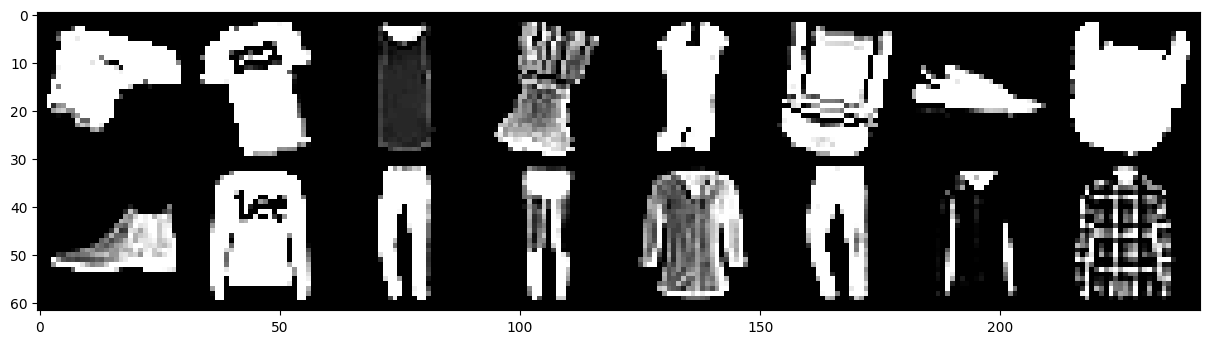

In [54]:
# Изображения тренировочного (1-я строка) и тестового (2-я) датасетов
show_images_from_dataset(train_loader_aug.dataset, test_loader_aug.dataset)

## Архитектура LeNet



### **Задание 1**: закончите имплементацию LeNet согласно диаграме сверху

In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),   # [28x28x6]
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # [14x14x6]
            nn.Conv2d(6, 16, kernel_size=5),             # [10x10x16]
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2)        # [5x5x16]
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(5*5*16, 120),                      # [120]
            nn.Sigmoid(),
            nn.Linear(120, 84),                          # [84]
            nn.Sigmoid(),
            nn.Linear(84, 10)                            # [10]
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)        # [400]  
        x = self.fc_layers(x)
        x = F.log_softmax(x, dim=1)        
        return x

### **Задание 2**: Напишите функцию обучения

Вы можете воспользоваться кодом из прошлой лабораторной работы

Посчитайте точность на валидационном сете. 

In [10]:
class LearningModel():
    def __init__(self, model, train_loader, test_loader, device='auto'):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

        # Определение устройства
        if device == 'auto':
            self.device_for_learning = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        elif device == 'cpu':
            self.device_for_learning = torch.device("cpu")
        elif device == 'cuda':
            self.device_for_learning = torch.device("cuda")
        else:
            raise ValueError("Invalid device choice. Use 'auto', 'cpu', or 'cuda'.")
        print('Device for learning: ', self.device_for_learning)

    def plot_metrics(self, note) -> None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        train_loss, test_loss, train_acc, test_acc = self.metrics.values()

        axes[0].set_title(f'Train loss: {train_loss[-1]:.2f}, Test loss: {test_loss[-1]:.2f}')
        axes[0].plot(train_loss, label='Train_loss')
        axes[0].plot(test_loss, label='Test_loss')

        axes[1].set_title(f'Train acc: {train_acc[-1]:.2f}, Test acc: {test_acc[-1]:.2f}')
        axes[1].plot(train_acc, label='Train_acc')
        axes[1].plot(test_acc, label='Test_acc')

        legend = [ax.legend() for ax in axes]

        fig.text(.41, .9, note)        
        
        plt.show()

    def learning_function(self, epochs=10, learning_rate=0.01, loss_func=nn.CrossEntropyLoss(), 
                          step_size=10, gamma=0.1, weight_decay=0.001):
        
        torch.manual_seed(42)

        self.metrics = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

        self.model.to(self.device_for_learning)
        
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Не знаем что взять - пробуем Adam
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # Планировщик скорости обучения

        # Цикл обучения
        
        for epoch in range(epochs):
            len_dataset = len(self.train_loader.dataset)
            loss_epoch_train, acc_epoch_train = 0, 0
            self.model.train()
            for data, target in self.train_loader: #tqdm_notebook(train_loader, desc='Train', leave=False): 
                #print(data.shape, target.shape)
                # переместить данные и таргеты на устройство для обучения
                data, target = data.to(self.device_for_learning), target.to(self.device_for_learning)

                # пропустить данные через модель и посчитать ошибку
                optimizer.zero_grad()
                logits = self.model(data)
                loss = loss_func(logits, target)

                # обучение сети
                loss.backward()
                optimizer.step()
                
                # так как ошибка усредняется по батчу, делаем обратную денормировку
                # чтобы потом просто разделить на длину датасета
                loss_epoch_train += loss.item() * target.size(0)
                acc_epoch_train += torch.sum(logits.argmax(dim=1) == target).item()        
            self.metrics['train_loss'].append(loss_epoch_train / len_dataset)
            self.metrics['train_acc'].append(acc_epoch_train / len_dataset)
            
            # Валидация
            self.model.eval()
            loss_epoch_eval, acc_epoch_eval  = 0, 0
            len_dataset = len(self.test_loader.dataset)        
            with torch.inference_mode():
                for data, target in self.test_loader: #tqdm_notebook(test_loader, desc='Validation', leave=False): 
                    # переместить данные и таргеты на устройство для обучения
                    data, target = data.to(self.device_for_learning), target.to(self.device_for_learning)
                    # пропустить данные через модель и посчитать ошибку
                    logits = self.model(data)
                    loss = loss_func(logits, target)
                    loss_epoch_eval += loss.item() * target.size(0)
                    acc_epoch_eval += torch.sum(logits.argmax(dim=1) == target).item()
            self.metrics['test_loss'].append(loss_epoch_eval / len_dataset)
            self.metrics['test_acc'].append(acc_epoch_eval / len_dataset)

            # отрисовка графиков
            clear_output(True)
            note = f"Epoch {epoch+1}/{epochs}, LR: {scheduler.get_last_lr()[0]:.12f}\n"
            self.plot_metrics(note)
            scheduler.step()


### **Задание 3**: Улучшите обучение продвинутыми методами

Вы можете добавить
- Dropout;
- BatchNorm;
- Data augmentation;
- Больше сверток к сети;
- Функции активации (ReLU, tahn, etc);
- Adam optimizer вместе с LR scheduler

In [11]:
class FashionLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # Увеличение фильтров + BatchNorm + ReLU
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            # Добавление глубины + увеличение фильтров
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            
            # Дополнительный сверточный слой
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  
        )
        
        self.fc_layers = nn.Sequential(
            # Регуляризация и современные практики
            nn.Linear(128*3*3, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x  # raw logits для CrossEntropyLoss

# Обучение моделей

In [12]:
EPOCHS = 30

## Обучение LeNet()

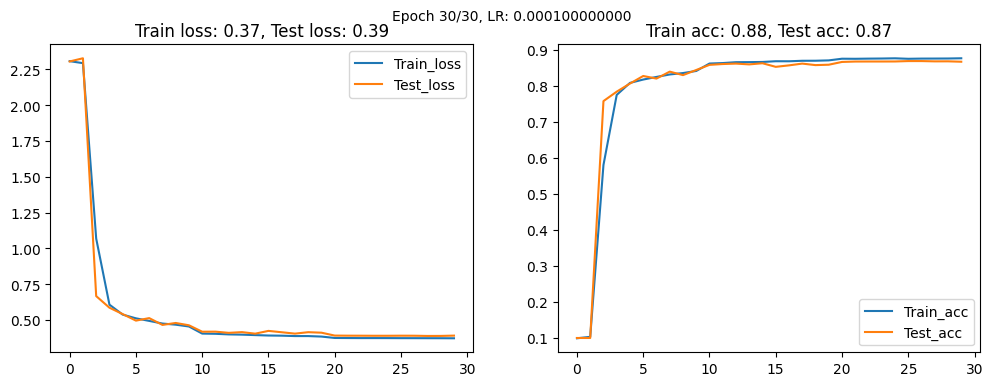

In [ ]:
# Ненормализованные данные
bad_lm = LearningModel(LeNet(), train_loader, test_loader, device='auto')
bad_lm.learning_function(epochs=25, loss_func=nn.NLLLoss())

Модель быстро обучается (примерно к 20-й эпохе и показывает неплохие результаты.)

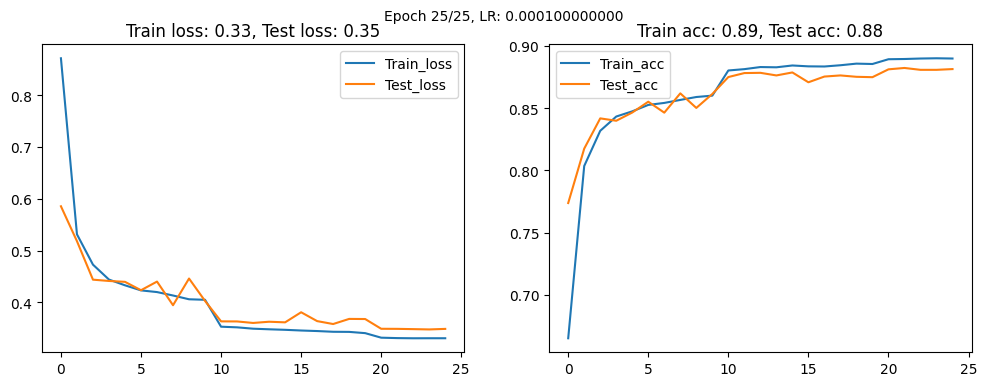

In [55]:
# Нормализованные данные
bad_lm_norm = LearningModel(LeNet(), train_loader_norm, test_loader_norm, device='auto')
bad_lm_norm.learning_function(epochs=25, loss_func=nn.NLLLoss())

На нормализованных данных результаты чуть-чуть лучше.

На нормализованных данных с аугментацией результаты похуже, чем с просто нормализацией. Что ожидаемо.
Добавление аугментации сблизило графики потерь на тренировочных и тестовых данных, но увеличилоо абсалютные значения функции потерь.

## Обучение FashionLeNet()

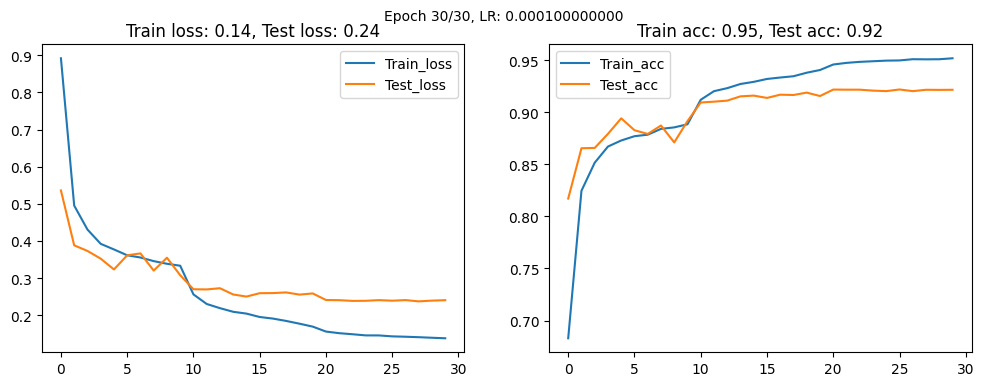

In [56]:
# Ненормализованные данные
fashion_lm = LearningModel(FashionLeNet(), train_loader, test_loader, device='auto')
fashion_lm.learning_function(epochs=EPOCHS, loss_func=nn.CrossEntropyLoss(), weight_decay=0.0001)

Эта модель показала результаты получше.

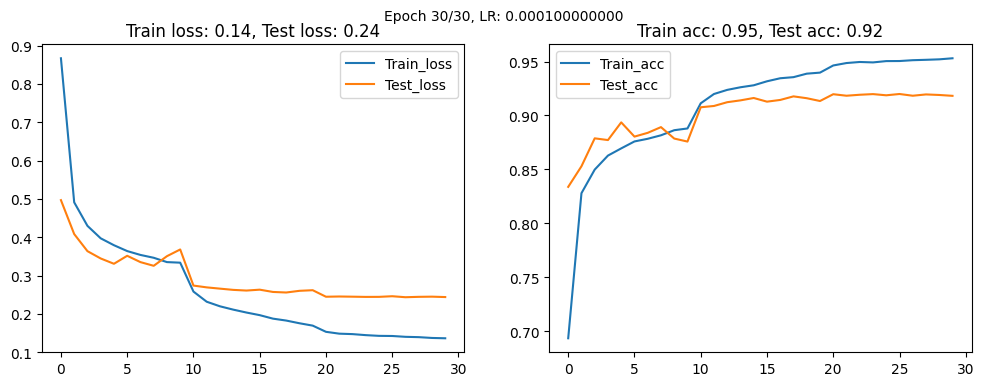

In [57]:
# Нормализованные данные
fashion_lm_norm = LearningModel(FashionLeNet(), train_loader_norm, test_loader_norm, device='auto')
fashion_lm_norm.learning_function(epochs=EPOCHS, loss_func=nn.CrossEntropyLoss(), weight_decay=0.0001)

Модифицированная модель, нормализация данных и L2-регуляризация позволили примерно на 5% улучшить accuracy и заметно уменьшить loss.